<a href="https://colab.research.google.com/github/Hurri301/Advanced-Computational-Techniques-for-Big-Imaging-and-Signal-Data/blob/main/Transformer_places_classification_128_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq ipdb
!pip install torchmetrics
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl

In [ ]:
import ipdb
import time

import numpy as np
import pandas as pd
import os
from os.path import join
import glob
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from PIL import Image
import random
from tqdm import tqdm


from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from torchmetrics import Accuracy

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

torch.manual_seed(123)
from tqdm.notebook import tqdm

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
## define parameters
train_on_gpu = torch.cuda.is_available() ## it will return True or False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
try:
    dataset_path = '/kaggle/input/places2-mit-dataset/train_256_places365standard/data_256/'

    ## Get the total No of Folders
    main_folders = os.listdir( dataset_path )
    print(len(main_folders))

except Exception as e:
    print(e)
    print('Running inside the Except with different path')
    dataset_path = '/kaggle/input/train_256_places365standard/data_256/'

    ## Get the total No of Folders
    main_folders = os.listdir( dataset_path )
    print(len(main_folders))

24


## Load the data file

In [ ]:
df = pd.read_csv( '/kaggle/input/dataset/places_data.csv' ).drop( 'Unnamed: 0', axis = 1 )
print(df.shape)
df.head(5)

(1803460, 2)


,file_name,class
0,f^forest^broadleaf#00002273.jpg,f^forest^broadleaf
1,a^auditorium#00004236.jpg,a^auditorium
2,i^ice_cream_parlor#00000914.jpg,i^ice_cream_parlor
3,s^swimming_hole#00003206.jpg,s^swimming_hole
4,d^desert^sand#00003949.jpg,d^desert^sand


In [ ]:
# Shuffle the rows of the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,file_name,class
0,g^greenhouse^indoor#00000849.jpg,g^greenhouse^indoor
1,p^palace#00001112.jpg,p^palace
2,j^jewelry_shop#00002206.jpg,j^jewelry_shop
3,s^stage^outdoor#00004563.jpg,s^stage^outdoor
4,v^vineyard#00000743.jpg,v^vineyard


## Displaying some sample Images from the dataset

In [ ]:
image_paths = []
for i in range(10):
    image_name = df.iloc[i]['file_name'].split('#')[1]
    sub_path   = '/'.join(df.iloc[i]['file_name'].split('#')[0].split('^'))
    image_path = join( dataset_path, sub_path, image_name )
    image_paths.append( image_path )

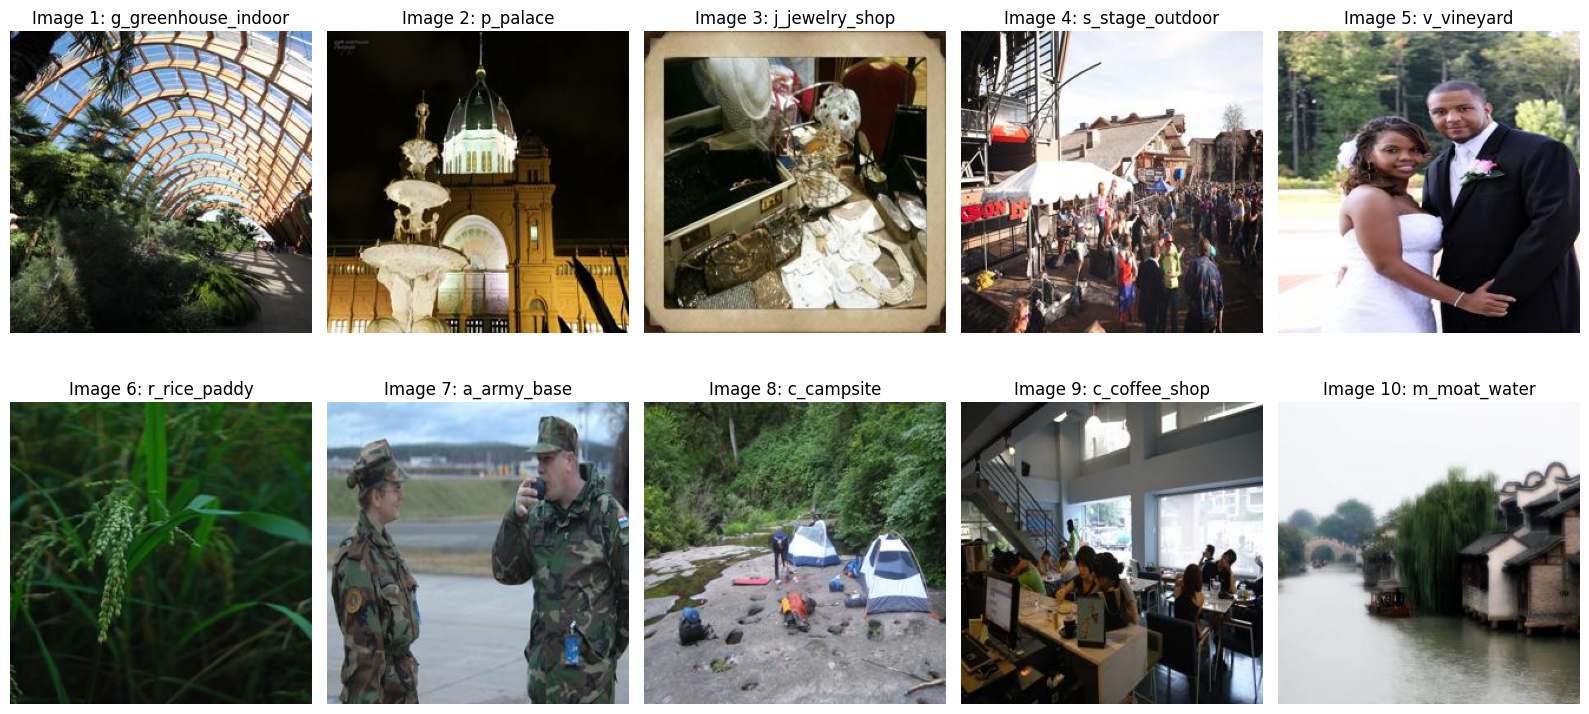

In [ ]:
# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop over the image paths and display each image in a subplot
for i, img_path in enumerate(image_paths):
    image_name = '_'.join(img_path.split('data_256')[1].split('/')[1:-1])
    img = plt.imread(img_path)

    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'Image {i+1}: {image_name}')  # Set title (optional)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Class Distribution
#### We have 365 classes in the dataset. Except the following 26 classes, all the other classes have 5000 images

In [ ]:
df['class'].value_counts().index[-26:]

Index(['p^pet_shop', 'g^greenhouse^outdoor', 'g^gymnasium^indoor',
       'o^operating_room', 'v^veterinarians_office', 'g^general_store^indoor',
       'b^bullring', 'e^elevator^door', 'c^crevasse', 'b^bazaar^indoor',
       'v^volleyball_court^outdoor', 'g^galley', 'm^market^indoor',
       'e^escalator^indoor', 'a^assembly_line', 'i^ice_skating_rink^indoor',
       's^sauna', 'c^clean_room', 'f^fabric_store', 'd^drugstore',
       'c^computer_room', 'b^bank_vault', 'b^biology_laboratory',
       'c^chemistry_lab', 'j^jacuzzi^indoor', 'd^dressing_room'],
      dtype='object', name='class')

In [ ]:
print( len(df['class'].value_counts().values[-26:]) )

## no of images per class
df['class'].value_counts().values[-26:]

26


array([4988, 4939, 4906, 4826, 4809, 4735, 4681, 4461, 4457, 4421, 4366,
       4330, 4266, 4254, 4168, 4104, 4020, 3871, 3858, 3781, 3619, 3500,
       3469, 3447, 3116, 3068])

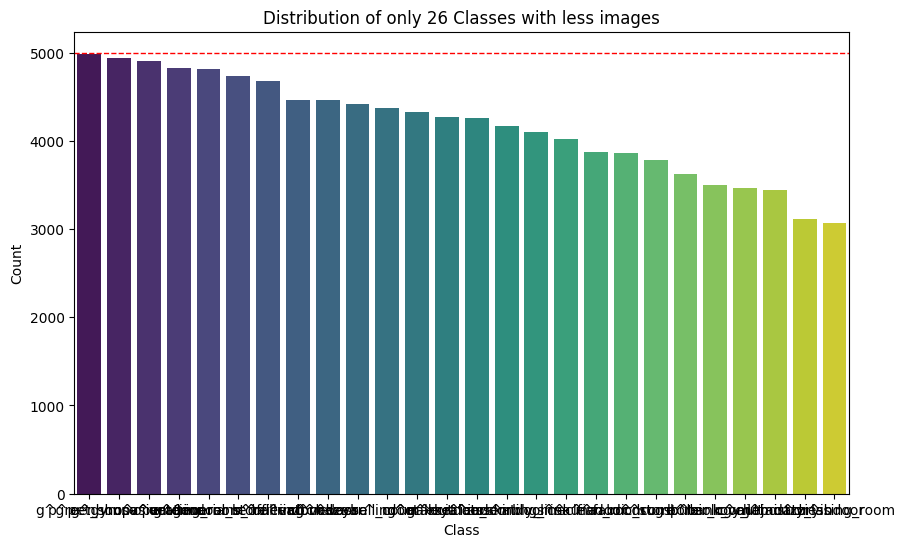

In [ ]:
# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot( x = df['class'].value_counts().index[-26:],
             y = df['class'].value_counts().values[-26:], palette='viridis')

# Add a horizontal line at y=5000
plt.axhline( y = 5000, color = 'red', linestyle = '--', linewidth = 1 )

plt.title('Distribution of only 26 Classes with less images')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Dropping (26) classes with < 5000 images

In [ ]:
classes_to_remove = df['class'].value_counts().index[-26:].tolist()
print(len(classes_to_remove))

26


In [ ]:
df_ = df[~df['class'].isin(classes_to_remove)]
print(df_.shape)
df_.head(5)

(1695000, 2)


,file_name,class
0,g^greenhouse^indoor#00000849.jpg,g^greenhouse^indoor
1,p^palace#00001112.jpg,p^palace
2,j^jewelry_shop#00002206.jpg,j^jewelry_shop
3,s^stage^outdoor#00004563.jpg,s^stage^outdoor
4,v^vineyard#00000743.jpg,v^vineyard


## Assign labels to classes using LabelEncoder

In [ ]:
## 339 total classes

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'class' column
df['label']  = label_encoder.fit_transform(df['class'])

# Display the updated dataframe
print(df.shape)
df.head(5)

(1803460, 3)


,file_name,class,label
0,g^greenhouse^indoor#00000849.jpg,g^greenhouse^indoor,165
1,p^palace#00001112.jpg,p^palace,252
2,j^jewelry_shop#00002206.jpg,j^jewelry_shop,198
3,s^stage^outdoor#00004563.jpg,s^stage^outdoor,316
4,v^vineyard#00000743.jpg,v^vineyard,349


In [ ]:
## total number of classes left
num_classes = len(df['label'].value_counts())
num_classes

365

## Dividing data into Train, Test and validation
- Train:      60 %
- Test:        20 %
- Valid: 20 %

In [ ]:
# First, split the data into 60% train and 40% temp (test + validation)
df_train, temp_df = train_test_split( df, test_size = 0.4, stratify = df['label'], random_state = 42 )

# Then, split the temp (40%) into 20% test and 20% validation
df_test, df_valid = train_test_split( temp_df, test_size = 0.5, stratify = temp_df['label'], random_state = 42 )

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

# Check the sizes of the splits
print(f"Train set size: {len(df_train)} -- {(df_train.shape[0]/df.shape[0])*100} %")
print(f"Test set size:  {len(df_test)}  -- {(df_test.shape[0]/df.shape[0])*100} %")
print(f"Valid set size: {len(df_valid)}  -- {(df_valid.shape[0]/df.shape[0])*100} %")

Train set size: 1082076 -- 60.0 %
Test set size:  360692  -- 20.0 %
Valid set size: 360692  -- 20.0 %


## Create Data set

In [ ]:
## Transformations
im_size = 128

train_transforms = T.Compose( [ T.Resize( im_size ),
                                T.ToTensor(), ] )

val_transforms   = T.Compose( [ T.Resize( im_size ),
                                T.ToTensor(), ] )

In [ ]:
class Dataset_class(Dataset):

    def __init__( self, root_path, df, transforms = None ):
        super( Dataset, self ).__init__()

        self.df         = df
        self.root_path  = root_path
        self.transforms = transforms

    def __getitem__( self, index ):
        try:
            image_name = self.df.iloc[index]['file_name'].split('#')[1]
            sub_path   = '/'.join(self.df.iloc[index]['file_name'].split('#')[0].split('^'))
            image_path = join( self.root_path, sub_path, image_name )

            # Check if the file exists
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"File '{image_path}' does not exist.")


            inp = Image.open( image_path )
            gt  = torch.tensor(  self.df.iloc[index]['label'] , dtype = torch.long )

            if self.transforms is not None:
                inp = self.transforms( inp )

            return inp, gt

        except Exception as e:
            print(f"Error loading index {index}: {e}")
            raise

    def __len__(self):
        return len(self.df)


In [ ]:
### Testing dataset class
train_set = Dataset_class( dataset_path, df_train, train_transforms )

transformed_images = []
for i in range(1):

    inp, label = train_set.__getitem__(i)
    print(f'Input shape: {inp.shape}')
    print(f'Label:       {label}')

    class_ = df_train[ df_train['label'] == int(label) ]['class'].iloc[0].replace('^', '_')
    print(f'Class:        {class_}\n')

    transformed_images.append( [ inp, class_ ] )

Input shape: torch.Size([3, 128, 128])
Label:       86
Class:        c_cemetery



In [ ]:
train_set = Dataset_class( dataset_path, df_train, train_transforms )
valid_set = Dataset_class( dataset_path, df_valid, val_transforms )
test_set  = Dataset_class( dataset_path, df_test,  val_transforms )

print(f'Length of train set: {train_set.__len__()}')
print(f'Length of valid set: {valid_set.__len__()}')
print(f'Length of test  set: {test_set.__len__()}')

Length of train set: 1082076
Length of valid set: 360692
Length of test  set: 360692


In [ ]:
batch_size  = 1000 # 100
num_workers = 4

In [ ]:
## Create dataloaders
train_loader = DataLoader( dataset = train_set, num_workers = num_workers, batch_size = batch_size, shuffle = True )
valid_loader = DataLoader( dataset = valid_set, num_workers = num_workers, batch_size = batch_size, shuffle = True )
test_loader  = DataLoader( dataset = test_set,  num_workers = num_workers, batch_size = batch_size, shuffle = True )

print(f'Length of train loader: {len(train_loader)}')
print(f'Length of valid loader: {len(valid_loader)}')
print(f'Length of test  loader: {len(test_loader)}')


Length of train loader: 1083
Length of valid loader: 361
Length of test  loader: 361


## Transformers for Classification

## 1. Patch Embedding Class

In [ ]:
class PatchEmbedding( nn.Module ):
    """
    Inputs:
        im_size
        patch_size
        in_channels
        embed_dim

    Attributes:
        number of patches
        Convolutional layer  for splitting and embedding
    """

    def __init__( self, im_size, patch_size, in_channels = 3, dim_emb = 768 ):
        # Create the Patch Embedding with the following attributes:
        # im_size
        # patch_size

        super().__init__()
        self.im_size    = im_size
        self.patch_size = patch_size

        # Create the embedding using Conv2d instead of linear projection (same operation)
        self.proj = nn.Conv2d(  in_channels  = in_channels,
                                out_channels = dim_emb,
                                kernel_size  = patch_size,
                                stride       = patch_size)

    def forward(self, x): # torch.Size([4, 3, 224, 224])
        # initial input shape ---> ( batch_size, in_channels, im_size, im_size )
        # Compute the the embedding, the final shape has to be (batch_size, num_patches, dim_emb)

        # convolution
        x = self.proj(x)
        # ( batch_size, dim_emb, num_patches_height, num_patches_width )
#         print('\npatches after convolution:\t\t\t' + str(x.shape)) # torch.Size([4, 768, 14, 14])

        x = x.flatten(2)
        # ( batch_size, dim_emb, num_patches_height * num_patches_width )
#         print('patches after flatten on dimension 2 and 3:\t' + str(x.shape)) # torch.Size([4, 768, 196])

        x = x.transpose(1,2)
        # (batch_size, num_patches, dim_emb)
#         print('patch embeddings:\t\t\t\t' + str(x.shape)) # torch.Size([4, 196, 768])

        return x

## Test the Patch Embedding Class

In [ ]:
im_size     = 128
patch_size  = 16
in_channels = 3
batch_size  = 4
dim_emb     = 768

# create an object of PatchEmbedding class
test_embedding  = PatchEmbedding( im_size, patch_size, in_channels, dim_emb )

## Fake input
batch_sample    = torch.rand( batch_size, in_channels, im_size, im_size ) # batch of 4 images
print(f'Input shape:                  {batch_sample.shape}')

batch_embedding = test_embedding( batch_sample )

print(f'Output-Batch embedding Shape: {batch_embedding.shape}') # expected output --> (batch_size, num_patches, dim_emb) --> torch.Size([4, 196, 768])

Input shape:                  torch.Size([4, 3, 128, 128])
Output-Batch embedding Shape: torch.Size([4, 64, 768])


## 2. Multi-Head Attention

In [ ]:
class Attention( nn.Module ):
    """
        Inputs..........
        dim:      embedding dimension per features token
        n_heads:  number of attention head
        qkv_bias: bool
        attn_p:   Probability Dropout on qkv
        proj_p:   Probability Dropout on output tensor
        Attributes......
        scale:     normalize the dot product
        qkv:       linear_projection
        proj:      linear layer for the concatenated output of the attention module
        attn_drop: nn.Dropout
    """

    def __init__( self, dim, n_heads = 12, qkv_bias = True, attn_p = 0., proj_p = 0. ): # dim = 768

        super().__init__()
        self.dim       = dim
        self.n_heads   = n_heads
        self.head_dim  = dim // n_heads # = 64
        self.scale     = self.head_dim ** - 0.5 # dk is a scaling factor to keep softmax under control

        # dim*3 because query, key and value are projected together and then splitted
        self.qkv       = nn.Linear( dim, dim * 3, bias = qkv_bias )
        self.attn_drop = nn.Dropout(attn_p)
        self.proj      = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):

        # input shape --> torch.Size([4, 196, 768])
        """
        x.shape = (n_samples, n_patches + 1, dim) --> n_patches + 1 because of the class token
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim: # sanity check
            raise ValueError

        # from on now n_patches = n_patches + 1
        # create q, k, and v and divide the embedding for the number of heads

        qkv = self.qkv(x)
        # qkv --> [ n_samples, n_patches, dim*3 ] --> output --> ([4, 196, 2304])
        # print(f'This is the shape of qkv: {qkv.shape}')

        qkv = qkv.reshape( n_samples, n_tokens, 3, self.n_heads, self.head_dim )
        # divide query key and value for each token for each head
        # [n_samples, n_patches, 3, n_heads, head_dim] output --> ([4, 196, 3, 12, 64])
        # print(f'This is the shape of qkv after reshape: {qkv.shape}')

        qkv = qkv.permute(2,0,3,1,4)
        # [3, n_samples, n_heads, n_patches, head_dim] --> ([3, 4, 12, 196, 64])
        # print(f'This is the shape of qkv after permute: {qkv.shape}')

        q, k, v =  qkv[0], qkv[1], qkv[2]
        # divide query, key and value in different matrix
        # output [n_samples, n_heads, n_patches, head_dim] --> ([4, 12, 196, 64])
        # print(f'Shape of q: {q.shape}')

        # Compute self-attention between q, k, and v
        # Attention = Softmax( ( Q @ K.T) / scale) @ V with @ = dot product
        k_t = k.transpose(-2, -1)
        # [n_samples, n_heads, head_dim, n_patches] --> ([4, 12, 64, 196])
        # print(f'shape of k_t: {k_t.shape}')

        dp = (q @ k_t) * self.scale
        #  [n_samples, n_heads, n_patches, n_patches] --> ([4, 12, 196, 196])
        # print(f'Shape of dp: {dp.shape}')

        attn = dp.softmax( dim = -1 )
        # last dimenstion --> columns
        # [n_samples, n_heads, n_patches, n_patches]  --> ([4, 12, 196, 196])
        # print(f'Shape of attn" {attn.shape}')

        # print(attn.shape)
        # print(attn)
        # print(torch.sum(attn,dim=2))
        # print(torch.sum(attn,dim=3))
        # print(torch.sum(attn,dim=2).shape)
        # print(torch.sum(attn,dim=3).shape)
        # print(torch.sum(attn[0,0,0,:])) # row
        # print(torch.sum(attn[0,0,:,0])) # col

        attn = self.attn_drop( attn ) ## using dropout

        weighted_avg = attn @ v
        # [n_samples, n_heads, n_patches, head_dim] --> ([4, 12, 196, 64])
#         print(f'This is the shape of weighted average: {weighted_avg.shape}')
        # concatenate heads --> 12 heads

        weighted_avg = weighted_avg.transpose(1,2)
        # (n_samples, n_patches, n_head, head_dim) --> ([4, 196, 12, 64])
#         print(f'This is the shape of weighted average: {weighted_avg.shape}')

        weighted_avg = weighted_avg.flatten(2)
        # (n_samples, n_patches, dim) --> ([4, 196, 768])
#         print(f'This is the shape of weighted average: {weighted_avg.shape}')

        # project heads -- linear layer
        x = self.proj(weighted_avg)
        # (n_samples, n_patches, dim) --> ([4, 196, 768])
#         print(f'Shape of x: {x.shape}')

        x = self.proj_drop(x)

        return x

### Test Attention Module

In [ ]:
im_size     = 128
patch_size  = 16
in_channels = 3
batch_size  = 4
dim_emb     = 768
n_heads     = 12

test_embedding  = PatchEmbedding( im_size, patch_size, in_channels, dim_emb )
test_attention  = Attention( dim_emb, n_heads )

batch_sample    = torch.rand( batch_size, in_channels, im_size, im_size ) # batch of 4 images
print(f'Input shape:           {batch_sample.shape}')

batch_embedding = test_embedding( batch_sample ) # output --> ([4, 196, 768])
print(f'Batch embedding shape: {batch_embedding.shape}')

batch_attention = test_attention( batch_embedding )

# 768 * 3 = 2304
print(f'Attention shape:       {batch_attention.shape}') # expected output --> torch.Size([4, 196, 768])

Input shape:           torch.Size([4, 3, 128, 128])
Batch embedding shape: torch.Size([4, 64, 768])
Attention shape:       torch.Size([4, 64, 768])


## 3. MLP

In [ ]:
class MLP(nn.Module): # Multi Layer Perceptron
    """
    Inputs
    in_features
    hidden_features
    out_features
    proj_p
    Attributes
    fc
    act: nn.GELU activation function
    fc2
    drop
    """
    def __init__( self, in_features, hidden_features, out_features, proj_p = 0. ):
        super().__init__()
        self.fc1  = nn.Linear( in_features, hidden_features )
        self.act  = nn.GELU()
        self.fc2  = nn.Linear( hidden_features, out_features )
        self.drop = nn.Dropout( proj_p )

    def forward(self, x):
        # ([4, 196, 768])
        """
        x.shape() = (n_samples, n_patches + 1, in_features)
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        # (n_samples, n_patches + 1, hidden_features) --> ([4, 196, 384])
        # print(f'shape after fc1: {x.shape}')

        x = self.fc2(x)
        x = self.drop(x)
        # (n_samples, n_patches + 1, hidden_features) --> [4, 196, 10])
        # print(f'shape after fc2: {x.shape}')

        return x

## Test MLP Class

In [ ]:
in_features     = 768
hidden_features = 384
out_features    = 10

## create an object of MLP class
mlp = MLP( in_features, hidden_features, out_features )

## generate fake input
fake_input    = torch.rand( 4, 196, 768 )
print(f'Input shape:            {fake_input.shape}')

## test MLP class
test_mlp = mlp( fake_input )
print(f'MLP class output shape: {test_mlp.shape}')

Input shape:            torch.Size([4, 196, 768])
MLP class output shape: torch.Size([4, 196, 10])


## 4. Transformer Block

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, n_heads=12, mlp_ratio=4.0, qkv_bias=True, proj_p=0., attn_p=0.):
        """
        Parameters
        ----------
        dim :       int      embedding dimension.
        n_heads :   int      number of head attention.
        mlp_ratio : float    hidden size of the MLP (multi perceptron) module
        qkv_bias :  bool     DESCRIPTION.
        proj_p :   float     Dropout probability
        attn_p :   float     Dropout probability.

        Attrubutes
        ----------
        norm1, norm2, : LayerNorm
        attn : Attention module
        mlp : MLP module

        Returns
        -------
        None.
        """
        super().__init__()
        self.norm1 = nn.LayerNorm( dim, eps = 1e-06 )
        self.attn  = Attention( dim, n_heads = n_heads, qkv_bias = qkv_bias, attn_p =attn_p, proj_p = proj_p )
        self.norm2 = nn.LayerNorm( dim, eps = 1e-06 )

        hidden_features = int( dim * mlp_ratio )
        # print(f'This is the hidden features: {hidden_features}')
        self.mlp        = MLP( in_features = dim, hidden_features = hidden_features, out_features = dim, proj_p = proj_p )


    def forward(self, x):
        x = x + self.attn( self.norm1(x) ) # residual block
        x = x + self.mlp(  self.norm2(x) ) # residual block

        return x

## Testing Transformer Block

In [ ]:
## create an object of transformer block class
block = Block( dim = 768 )

## random inout to test the class
test_block = torch.rand( 4, 196, 768 )

print(f'Shape of the Transformer block output: {test_block.shape}')

Shape of the Transformer block output: torch.Size([4, 196, 768])


## 5. Vision Transformer model

In [ ]:
class VisionTransformer(nn.Module):

    def __init__( self, im_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, dim_emb = 768,
                  depth = 12, n_heads     = 12, mlp_ratio   = 4., qkv_bias = True, proj_p = 0., attn_p = 0.):
        """
        Parameters
        ----------
        img_size :   TYPE  DESCRIPTION.
        patch_size : TYPE  DESCRIPTION.
        in_chans :   TYPE  DESCRIPTION.
        n_classes :  TYPE  DESCRIPTION.
        embed_dim :  TYPE  DESCRIPTION.
        depth :      TYPE  number of transformers block.
        n_heads :    TYPE, optional   DESCRIPTION. The default is 12.
        mlp_ratio :  TYPE, optional   DESCRIPTION. The default is 4.0.
        qkv_bias :   TYPE, optional   DESCRIPTION. The default is True.
        proj_p :     TYPE, optional   DESCRIPTION. The default is 0..
        attn_p :     TYPE, optional   DESCRIPTION. The default is 0..

        Attrubutes
        ----------
        patch_embed
        cls_token
        pos_emb
        pos_drop
        blocks
        norm

        Returns
        -------
        None.
        """
        super().__init__()
        self.patch_embed = PatchEmbedding( im_size = im_size, patch_size = patch_size, in_channels = in_channels, dim_emb = dim_emb )

        # nn.Parameters create weights in the network that will be trained together with the other layers
        self.cls_token = nn.Parameter( torch.zeros( 1, 1, dim_emb ) ) # parameter of the network, first 2 dimesions are there for convenience during the operations

        n_patches     = ( im_size // patch_size ) ** 2
        self.pos_emb  = nn.Parameter( torch.zeros( 1, 1+n_patches, dim_emb ) ) # parameter of the network --> 1+self.patch_embed.n_patches beacause it includes class token
        self.pos_drop = nn.Dropout( p = proj_p )

        self.blocks = nn.ModuleList( [ Block( dim = dim_emb, n_heads = n_heads, mlp_ratio = mlp_ratio, qkv_bias = qkv_bias,
                                      proj_p = proj_p, attn_p = attn_p ) for _ in range( depth )  ] )

        self.norm = nn.LayerNorm( dim_emb, eps = 1e-06 )
        self.head = nn.Linear( dim_emb, n_classes ) # Classifier


    def forward(self, x):
        n_samples = x.shape[0]
        x         = self.patch_embed(x) # patch embeddings

        cls_token = self.cls_token.expand( n_samples, -1, -1 ) # [n_samples, 1, dim]
        x         = torch.cat( ( cls_token, x ), dim = 1 ) # add the cls token to the patch embeddings

        x = x + self.pos_emb # tokens creations
        x = self.pos_drop(x)

        # blocks executions
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_final_token = x[ :, 0 ] # just the class token
        x               = self.head( cls_final_token ) #

        return x

In [ ]:
## Set Parameters

im_size     = 128

# Transformer parameters
patch_size  = 16
in_channels = 3
dim_emb     = 192
num_heads   = 3
num_blocks  = 2
dropout     = 0.1

# Training parameter
epochs      = 20 # 50
lr          = 10e-4

## MODEL

In [ ]:
model = VisionTransformer( im_size     = im_size,
                           patch_size  = patch_size,
                           in_channels = in_channels,
                           n_classes   = num_classes,
                           dim_emb     = dim_emb,
                           depth       = num_blocks,
                           n_heads     = num_heads,
                           mlp_ratio   = 4.,
                           qkv_bias    = True,
                           proj_p      = 0.,
                           attn_p      = 0. )

In [ ]:
## Print model summary
summary( model.to(device), ( in_channels, im_size, im_size ) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 192, 8, 8]         147,648
    PatchEmbedding-2              [-1, 64, 192]               0
           Dropout-3              [-1, 65, 192]               0
         LayerNorm-4              [-1, 65, 192]             384
            Linear-5              [-1, 65, 576]         111,168
           Dropout-6            [-1, 3, 65, 65]               0
            Linear-7              [-1, 65, 192]          37,056
           Dropout-8              [-1, 65, 192]               0
         Attention-9              [-1, 65, 192]               0
        LayerNorm-10              [-1, 65, 192]             384
           Linear-11              [-1, 65, 768]         148,224
             GELU-12              [-1, 65, 768]               0
          Dropout-13              [-1, 65, 768]               0
           Linear-14              [-1, 

In [ ]:
def train( net, train_loader, val_loader, conf_train ):

    device                = conf_train['device']
    epochs                = conf_train['epochs']
    loss_function         = conf_train['loss_function'].to(device)
    train_metric_function = conf_train['metric_function'].to(device)
    val_metric_function   = train_metric_function.clone()
    optimizer             = conf_train['optimizer']

    net.to(device)

    # Needed Variables
    epochs_train_losses  = []
    epochs_val_losses    = []

    epochs_train_metrics = []
    epochs_val_metrics   = []

    epochs_train_metrics = []

    best_val_score = None
    decrease = 0

    # with tqdm(range(epochs)) as progress:
    for epoch in range(epochs):

        batch_train_losses = []
        batch_val_losses   = []

        for i, batch in enumerate( tqdm(train_loader) ):
            # print(f'Iteration: {i}')
            im, gt = batch

            im = im.to(device)
            gt = gt.to(device)

            pred = net(im)

            # compute train loss
            loss = loss_function(pred, gt)

            # compute train accuracy
            train_metric_function.update(pred, gt)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.detach().to('cpu'))


        epochs_train_losses.append(np.mean(batch_train_losses))
        epochs_train_metrics.append(train_metric_function.compute().to('cpu'))
        train_metric_function.reset()

        # Validation loop
        with torch.no_grad():
            for i, batch in enumerate( tqdm(val_loader) ):

                im, gt = batch
                im = im.to(device)
                gt = gt.to(device)

                pred = net(im)

                # compute val loss
                loss = loss_function(pred, gt)
                batch_val_losses.append(loss.detach().to('cpu'))

                # compute validation metrics
                val_metric_function.update(pred, gt)


            epochs_val_losses.append(np.mean(batch_val_losses))
            epochs_val_metrics.append(val_metric_function.compute().to('cpu'))
            val_metric_function.reset()

            print(f'Epoch: {epoch}', end = " ")
            print({ 'train_loss'     : np.round( epochs_train_losses[-1], 2 ),
                    'train_acc'      : np.round( epochs_train_metrics[-1], 2 ),
                    'validation_loss': np.round( epochs_val_losses[-1], 2 ),
                    'validation_acc' : np.round( epochs_val_metrics[-1], 2 ),})
            print()

            cur_val_score = np.mean(batch_val_losses)
            #  check if it is the best model so far
            if best_val_score is None or cur_val_score < best_val_score:
                best_val_score = cur_val_score
                print('SAVING MODEL .....................')

                data = {
                  'net'   : net.state_dict(),
                  'opt'   : optimizer.state_dict(),
                  'epoch' : epoch
                }

                torch.save( data, '_best.pth')
            else:
                decrease += 1
                print(f"LOSS DOESN'T DECREASE {decrease} TIME")

    # save the last model
    data = {
        'net'   : net.state_dict(),
        'opt'   : optimizer.state_dict(),
        'epoch' : epoch
    }
    torch.save( data, '_last.pth' )

    losses  = { 'train_losses'  : epochs_train_losses,  'val_losses'  : epochs_val_losses, }
    metrics = { 'train_metrics' : epochs_train_metrics, 'val_metrics' : epochs_val_metrics, }

    return net, losses, metrics

In [ ]:
loss_function   = nn.CrossEntropyLoss()
metric_function = Accuracy( task = 'multiclass', num_classes = num_classes )
optimizer       = optim.Adam( model.parameters(), lr = lr )

## TRAINING

In [ ]:
conf_train = {
              'epochs' :          epochs, # epochs
              'loss_function' :   loss_function,
              'optimizer' :       optimizer,
              'metric_function' : metric_function,
              'device' :          device,
              }

new_model, losses, metrics = train( model, train_loader, valid_loader, conf_train )

  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 0 {'train_loss': 4.79, 'train_acc': tensor(0.0700), 'validation_loss': 4.37, 'validation_acc': tensor(0.1100)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 1 {'train_loss': 4.07, 'train_acc': tensor(0.1400), 'validation_loss': 3.95, 'validation_acc': tensor(0.1600)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 2 {'train_loss': 3.73, 'train_acc': tensor(0.1900), 'validation_loss': 3.75, 'validation_acc': tensor(0.1900)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 3 {'train_loss': 3.53, 'train_acc': tensor(0.2200), 'validation_loss': 3.59, 'validation_acc': tensor(0.2100)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 4 {'train_loss': 3.4, 'train_acc': tensor(0.2400), 'validation_loss': 3.46, 'validation_acc': tensor(0.2300)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 5 {'train_loss': 3.29, 'train_acc': tensor(0.2500), 'validation_loss': 3.38, 'validation_acc': tensor(0.2400)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 6 {'train_loss': 3.21, 'train_acc': tensor(0.2600), 'validation_loss': 3.44, 'validation_acc': tensor(0.2300)}

LOSS DOESN'T DECREASE 1 TIME


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 7 {'train_loss': 3.15, 'train_acc': tensor(0.2700), 'validation_loss': 3.3, 'validation_acc': tensor(0.2500)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 8 {'train_loss': 3.09, 'train_acc': tensor(0.2800), 'validation_loss': 3.26, 'validation_acc': tensor(0.2600)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 9 {'train_loss': 3.04, 'train_acc': tensor(0.2900), 'validation_loss': 3.24, 'validation_acc': tensor(0.2600)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 10 {'train_loss': 3.0, 'train_acc': tensor(0.3000), 'validation_loss': 3.2, 'validation_acc': tensor(0.2700)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 11 {'train_loss': 2.96, 'train_acc': tensor(0.3100), 'validation_loss': 3.17, 'validation_acc': tensor(0.2800)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 12 {'train_loss': 2.92, 'train_acc': tensor(0.3100), 'validation_loss': 3.19, 'validation_acc': tensor(0.2700)}

LOSS DOESN'T DECREASE 2 TIME


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 13 {'train_loss': 2.89, 'train_acc': tensor(0.3200), 'validation_loss': 3.12, 'validation_acc': tensor(0.2800)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 14 {'train_loss': 2.86, 'train_acc': tensor(0.3200), 'validation_loss': 3.11, 'validation_acc': tensor(0.2900)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 15 {'train_loss': 2.83, 'train_acc': tensor(0.3300), 'validation_loss': 3.11, 'validation_acc': tensor(0.2800)}

LOSS DOESN'T DECREASE 3 TIME


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 16 {'train_loss': 2.81, 'train_acc': tensor(0.3300), 'validation_loss': 3.11, 'validation_acc': tensor(0.2900)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 17 {'train_loss': 2.78, 'train_acc': tensor(0.3400), 'validation_loss': 3.08, 'validation_acc': tensor(0.2900)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 18 {'train_loss': 2.76, 'train_acc': tensor(0.3400), 'validation_loss': 3.07, 'validation_acc': tensor(0.2900)}

SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 19 {'train_loss': 2.74, 'train_acc': tensor(0.3400), 'validation_loss': 3.11, 'validation_acc': tensor(0.2900)}

LOSS DOESN'T DECREASE 4 TIME


In [ ]:
# Merge both results dictionaries
metrics.update(losses)

In [ ]:
# Convert tensors to floats
history = {
            'train_metrics': [metric.item() for metric in metrics['train_metrics']],
            'val_metrics'  : [metric.item() for metric in metrics['val_metrics']],
            'train_losses' : [float(metric) for metric in metrics['train_losses']],
            'val_losses'   : [float(metric) for metric in metrics['val_losses']]
}

## Saving model results dictionary

In [ ]:
import json

# Convert and write JSON object to file
with open("ViT_history.json", "w") as outfile:
    json.dump( history, outfile )

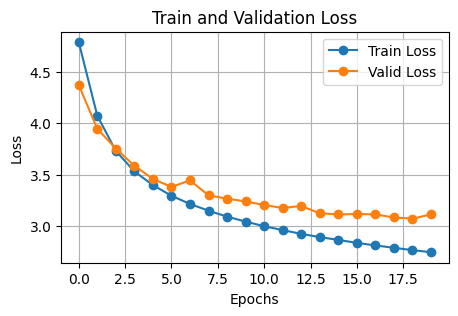

In [ ]:
# Plotting train and validation loss
plt.figure(figsize=(5, 3))
plt.plot(range(epochs), losses['train_losses'], label='Train Loss', marker = 'o' )
plt.plot(range(epochs), losses['val_losses'],   label='Valid Loss', marker = 'o' )
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

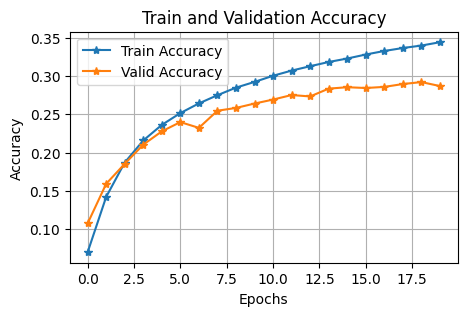

In [ ]:
# Plotting train and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot( range(epochs), metrics['train_metrics'], label='Train Accuracy',      marker = '*' )
plt.plot( range(epochs), metrics['val_metrics'],   label='Valid Accuracy', marker = '*' )
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Testing Model

In [ ]:
def test(net, test_loader, conf_test):

    device          = conf_train['device']
    epochs          = conf_train['epochs']
    # loss_function   = conf_train['loss_function'].to(device)
    metric_function = conf_train['metric_function'].to(device)
    # optimizer       = conf_train['optimizer']

    net.to(device)

    with torch.no_grad():
        for i, batch in enumerate( tqdm(test_loader) ):

            im, gt = batch

            im = im.to(device)
            gt = gt.to(device)

            pred = net(im)

            # compute metrics
            metric_function.update(pred, gt)


        metric = metric_function.compute()
        metric_function.reset()

    ## returning the gt and pred of the last batch of test loader for analysis purpose
    return metric, gt, pred


In [ ]:
test_metrics, actual, pred = test( new_model, test_loader, conf_train )
print(f'Test Accuracy: {test_metrics}')

  0%|          | 0/361 [00:00<?, ?it/s]

Test Accuracy: 0.2858893573284149
